In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset

import numpy as np
import h5py
import os
from glob import glob



In [27]:
config = {
    
    'data_dir1' : "./human2robot/grab_cube2_v1",
    # 'data_dir2' : "/content/drive/MyDrive/PRML/1735725078_042906",
    'batch_size' : 32
}
data_files = list(sorted(glob(os.path.join(config['data_dir1'],'*.hdf5'))))
print(data_files)

['./human2robot/grab_cube2_v1\\episode_0.hdf5', './human2robot/grab_cube2_v1\\episode_1.hdf5', './human2robot/grab_cube2_v1\\episode_10.hdf5', './human2robot/grab_cube2_v1\\episode_11.hdf5', './human2robot/grab_cube2_v1\\episode_12.hdf5', './human2robot/grab_cube2_v1\\episode_13.hdf5', './human2robot/grab_cube2_v1\\episode_14.hdf5', './human2robot/grab_cube2_v1\\episode_15.hdf5', './human2robot/grab_cube2_v1\\episode_16.hdf5', './human2robot/grab_cube2_v1\\episode_17.hdf5', './human2robot/grab_cube2_v1\\episode_18.hdf5', './human2robot/grab_cube2_v1\\episode_19.hdf5', './human2robot/grab_cube2_v1\\episode_2.hdf5', './human2robot/grab_cube2_v1\\episode_20.hdf5', './human2robot/grab_cube2_v1\\episode_21.hdf5', './human2robot/grab_cube2_v1\\episode_22.hdf5', './human2robot/grab_cube2_v1\\episode_23.hdf5', './human2robot/grab_cube2_v1\\episode_24.hdf5', './human2robot/grab_cube2_v1\\episode_25.hdf5', './human2robot/grab_cube2_v1\\episode_26.hdf5', './human2robot/grab_cube2_v1\\episode_27.h

In [28]:
class HDF5Dataset(Dataset):
    def __init__(self, hdf5_file):
        """
        初始化数据集，读取HDF5文件
        :param hdf5_file: HDF5文件路径
        """
        self.hdf5_file = hdf5_file
        # 打开HDF5文件
        with h5py.File(hdf5_file, 'r') as f:
            # 读取数据集中的图像、状态和动作
            self.camera_images = f['cam_data']['human_camera'][:]
            
            data = f['/end_position'][:]
            gripper_state = f['/gripper_state'][:]
            
            gripper_state_tensor = torch.tensor(gripper_state, dtype=torch.float32)
            data_tensor = torch.tensor(data, dtype=torch.float32)
            
            if gripper_state_tensor.dim() == 1:
                gripper_state_tensor = gripper_state_tensor.unsqueeze(1)  # 转为 [num_samples, 1]
            
            data = torch.cat((data_tensor, gripper_state_tensor), dim=1)
            
            self.states = data
            self.actions = f['action'][:]

        # 获取数据集的大小
        self.num_samples = len(self.camera_images)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # 获取单个样本的图像、状态和动作
        camera_image = torch.tensor(self.camera_images[idx], dtype=torch.float32)
        camera_image = camera_image.permute(2, 0, 1)
        state = self.states[idx]
        # state = torch.tensor(self.states[idx], dtype=torch.float32)
        action = torch.tensor(self.actions[idx], dtype=torch.float32)
        return camera_image, state, action
dataset = ConcatDataset([HDF5Dataset(fn) for fn in data_files])
# dataset=HDF5Dataset()
dataloader = DataLoader(dataset, batch_size=config['batch_size'], shuffle=True,drop_last=True,num_workers=0)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models
# 生成器（Generator）
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # 图像特征提取部分 (假设图像是256x256x3)
        resnet = models.resnet18(pretrained=True)  # 使用预训练的ResNet-18模型
        self.resnet = nn.Sequential(
            *list(resnet.children())[:-1]  # 去除最后的全连接层
        )
        self.resnet_fc = nn.Linear(resnet.fc.in_features, 256)  # 将ResNet输出的特征维度映射到128维

        # 机械臂信息的处理部分
        self.fc_arm = nn.Linear(7, 128)  # 机械臂信息大小为32

        # 合并图像和机械臂信息的全连接层
        self.fc_fusion = nn.Linear(256 + 128, 128)

        # 输出层，生成动作（7维向量）
        self.fc_out = nn.Linear(128, 7)

    def forward(self, image, arm_state):
        # 图像特征提取
        x_img = self.resnet(image)
        x_img = x_img.view(x_img.size(0), -1)  # 展平图像的输出
        x_img = F.relu(self.resnet_fc(x_img))  # 用一个全连接层将特征映射到128维

        # 机械臂信息处理
        x_arm = F.relu(self.fc_arm(arm_state))

        # 融合图像和机械臂信息
        x_fused = torch.cat((x_img, x_arm), dim=1)

        # 融合后的全连接层
        x_fused = F.relu(self.fc_fusion(x_fused))

        # 生成动作
        action = self.fc_out(x_fused)
        return action

# 判别器（Discriminator）
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # 图像特征提取部分（与生成器相似）
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.fc_image = nn.Linear(60 * 107 * 64, 64)

        # 机械臂信息处理部分（与生成器相同）
        self.fc_arm = nn.Linear(7, 64)

        # 合并图像和机械臂信息的全连接层
        self.fc_fusion = nn.Sequential(
            nn.Linear(64 + 64 + 7, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
        )

        # 判别层，输出动作是否来自专家（1为专家，0为生成器）
        self.fc_out = nn.Linear(128, 1)

    def forward(self, image, arm_state, action):
        # 图像特征提取
        x_image = F.relu(self.conv1(image))
        x_image = F.relu(self.conv2(x_image))
        x_image = x_image.view(x_image.size(0), -1)  # 展平
        x_image = F.relu(self.fc_image(x_image))

        # 机械臂信息处理
        x_arm = F.relu(self.fc_arm(arm_state))

        # 融合图像和机械臂信息
        x_fused = torch.cat((x_image, x_arm, action), dim=1)

        # 判别层
        x_fused = F.relu(self.fc_fusion(x_fused))
        output = torch.sigmoid(self.fc_out(x_fused))  # 输出为概率（0~1）
        return output


In [30]:

# 初始化生成器和判别器
generator = Generator()
discriminator = Discriminator()

# 初始化
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=0.00002, weight_decay=1e-5)
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.00002, weight_decay=1e-5)

# 用来存储每个epoch的损失
loss_g_list = []
loss_d_list = []
max_loss = 100

c:\Users\60264\miniconda3\envs\testenvironment\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\60264\miniconda3\envs\testenvironment\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cuda')
generator.to(device)
discriminator.to(device)

Discriminator(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (fc_image): Linear(in_features=410880, out_features=64, bias=True)
  (fc_arm): Linear(in_features=7, out_features=64, bias=True)
  (fc_fusion): Sequential(
    (0): Linear(in_features=135, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (fc_out): Linear(in_features=128, out_features=1, bias=True)
)

In [32]:
# 假设你已经定义了一个优化器 optimizer
# 例如：optimizer = optim.Adam(model.parameters(), lr=0.001)

# 设置新的学习率
new_lr = 0.00002
for param_group in optimizer_g.param_groups:
    param_group['lr'] = new_lr
for param_group in optimizer_d.param_groups:
    param_group['lr'] = new_lr


In [33]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt

# 假设你已经定义了generator, discriminator等
# 例如 generator = Generator(), discriminator = Discriminator()

def compute_gradient_penalty(discriminator, real_data, fake_data, device):
    # 随机生成λ
    alpha = torch.rand(real_data.size(0), 1).to(device)
    alpha = alpha.expand(real_data.size(0), real_data.nelement() // real_data.size(0)).contiguous().view_as(real_data)
    interpolated_data = alpha * real_data + ((1 - alpha) * fake_data)
    interpolated_data = interpolated_data.requires_grad_(True)

    # 判别器对插值数据的输出
    d_interpolated = discriminator(interpolated_data)

    # 计算梯度
    gradients = torch.autograd.grad(outputs=d_interpolated, inputs=interpolated_data,
                                   grad_outputs=torch.ones(d_interpolated.size()).to(device),
                                   create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()  # 计算梯度惩罚
    return gradient_penalty

for epoch in range(80):  # 假设训练100个epoch
    running_loss_gen = 0.0
    running_loss_dis = 0.0

    # 使用 tqdm 来显示进度条
    with tqdm(dataloader, desc=f"Epoch {epoch+1}", unit="batch") as pbar:
        for camera_image, state, action in pbar:
            # 清零梯度
            optimizer_d.zero_grad()

            camera_image = camera_image.to(device)
            state = state.to(device)
            action = action.to(device)
            noise = torch.randn_like(action) * 0.01
            action += noise


            # 来自专家的真实数据
            real_labels = torch.ones(config['batch_size'], 1).to(device)  # 标签1代表专家
            real_output = discriminator(camera_image, state, action)
            loss_real = real_output.mean()

            # 来自生成器的假数据
            fake_actions = generator(camera_image, state)  # 生成器生成的动作
            noise = torch.randn_like(fake_actions) * 0.1
            fake_actions += noise

            fake_labels = torch.zeros(config['batch_size'], 1).to(device)  # 标签0代表生成器
            fake_output = discriminator(camera_image, state, fake_actions.detach())  # 生成器的输出是假的，标记为0
            loss_fake = fake_output.mean()

            # 判别器总损失
            loss_d = - loss_real + loss_fake
            loss_d.backward()
            optimizer_d.step()

            # 训练生成器
            optimizer_g.zero_grad()

            # 生成器目标是欺骗判别器，标签应为1
            fake_output = discriminator(camera_image, state, fake_actions)
            loss_g = criterion(fake_output, real_labels)  # 生成器的损失是让判别器认为它的输出是真的
            loss_g.backward()
            optimizer_g.step()

            # 更新运行损失
            running_loss_gen += loss_g.item()
            running_loss_dis += loss_d.item()

            # 更新进度条
            pbar.set_postfix(loss_d=loss_d.item(), loss_g=loss_g.item())
        if running_loss_gen / len(dataloader) < max_loss:
          torch.save(generator.state_dict(),'best_gail_model_1710.pth')
        # 保存每个epoch的损失
        loss_g_list.append(running_loss_gen / len(dataloader))
        loss_d_list.append(running_loss_dis / len(dataloader))

    # 输出每个epoch的损失
    # print(f'Epoch [{epoch+1}/100], Loss D: {running_loss_dis / len(dataloader):.4f}, Loss G: {running_loss_gen / len(dataloader):.4f}')




Epoch 3:   6%|▋         | 24/372 [00:18<04:23,  1.32batch/s, loss_d=2.65e-6, loss_g=13.7] 


KeyboardInterrupt: 

In [2]:
from test_robot import Xarm
from video_receiver import VideoStreamer
import torch
import numpy as np
from einops import rearrange
import signal
import sys



model = Generator()
model.load_state_dict(torch.load('./best_gail_model.pth'))
model.eval().to('cuda')

robot = Xarm("10.177.63.209")
robot.move_gripper_percentage(1)
robot.home()

print(robot.get_cartesian_position())

def handler(signum, frame):
    robot.stop()

signal.signal(signal.SIGINT, handler)

video_streamer = VideoStreamer("10.177.63.229", 10005)
result = video_streamer.get_image_tensor()
print(result.shape)

max_steps = 100

for step in range(max_steps):
    qpos = robot.get_cartesian_position()
    gripper_state = robot.get_gripper_state()
    state = np.append(qpos, gripper_state)
    
    image = video_streamer.get_image_tensor()
    image = rearrange(image, 'h w c -> c h w')
    
    
    state = torch.from_numpy(state).float().cuda().unsqueeze(0)
    image = torch.from_numpy(image).float().cuda().unsqueeze(0)
    
    action = model(image, state)[0][:]
    

    target_qpos = action[:6]
    target_gripper_state = action[-1]
    print(f'{target_qpos=}, {target_gripper_state=}')
    if target_gripper_state > 0.5:
        target_gripper_state = 1
    else:
        target_gripper_state = 0
    robot.move_gripper_percentage(target_gripper_state)
    robot.move_coords(target_qpos)
    
robot.stop()
    

SDK_VERSION: 1.14.7


c:\Users\60264\miniconda3\envs\testenvironment\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\60264\miniconda3\envs\testenvironment\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\60264\AppData\Local\Temp\ipykernel_9080\3620309411.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https:/

ROBOT_IP: 10.177.63.209, VERSION: v2.5.1, PROTOCOL: V1, DETAIL: 7,7,XS1304,AC1303,v2.5.1, TYPE1300: [1, 1]
change protocol identifier to 3
[ 151.20055   312.30005    -0.999823 -180.00002    -0.         89.999985]
(240, 426, 3)
target_qpos=tensor([165.1594, 403.4052, -37.1080, 184.2512,   5.4256, 142.7773],
       device='cuda:0', grad_fn=<SliceBackward0>), target_gripper_state=tensor(-3.6119, device='cuda:0', grad_fn=<SelectBackward0>)
[SDK][ERROR][2025-01-03 21:07:51][base.py:380] - - wait_feedback, xarm is stop, state=4
ControllerError, code: 31
Xarm ErrorCode: 31, WarnCode: 0
target_qpos=tensor([242.5417, 443.0113, -55.0088, 216.4457,  -9.7567, 158.3701],
       device='cuda:0', grad_fn=<SliceBackward0>), target_gripper_state=tensor(9.1170, device='cuda:0', grad_fn=<SelectBackward0>)
[SDK][ERROR][2025-01-03 21:07:51][base.py:380] - - API -> set_modbus_gripper_position(pos=850) -> code=1
[SDK][ERROR][2025-01-03 21:07:51][base.py:380] - - API -> set_position -> code=1, pos=[242.541748

In [ ]:
# go home
robot = Xarm("10.177.63.209")
robot.move_gripper_percentage(1)
robot.home()
robot.stop()

ROBOT_IP: 10.177.63.209, VERSION: v2.5.1, PROTOCOL: V1, DETAIL: 7,7,XS1304,AC1303,v2.5.1, TYPE1300: [1, 1]
change protocol identifier to 3
[motion_enable], xArm is not ready to move
[set_state], xArm is ready to move


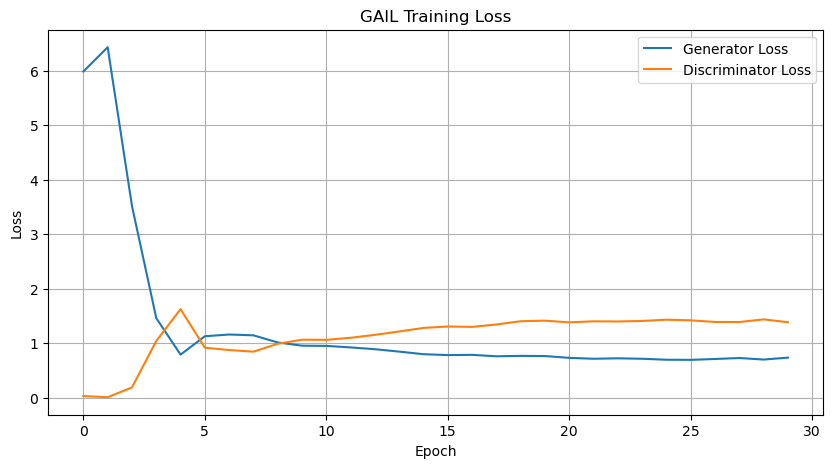

In [8]:
# 训练结束，绘制损失曲线
plt.figure(figsize=(10, 5))
plt.plot(range(len(loss_g_list)), loss_g_list, label="Generator Loss")
plt.plot(range(len(loss_d_list)), loss_d_list, label="Discriminator Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('GAIL Training Loss')
plt.grid(True)
plt.show()

In [9]:
for name,val in discriminator.named_parameters():
  print(name,val)

conv1.weight Parameter containing:
tensor([[[[-1.8374e-01, -6.3831e-02,  7.4200e-02],
          [ 6.9780e-02,  7.6033e-02, -2.8718e-02],
          [ 6.6556e-03,  7.3140e-02, -1.7422e-01]],

         [[ 1.5900e-01, -7.4119e-02,  1.8321e-01],
          [-4.8681e-03,  8.0550e-02,  1.0084e-01],
          [-1.7069e-01, -9.3414e-02, -4.9679e-02]],

         [[ 8.2282e-02,  1.0088e-01, -8.5582e-02],
          [-6.7788e-02,  1.0142e-01, -1.5999e-01],
          [ 7.5042e-02,  6.8121e-02,  1.3145e-01]]],


        [[[ 1.8840e-01, -1.0559e-01,  3.1656e-02],
          [-9.9743e-03,  1.3378e-01, -1.1341e-01],
          [-1.5399e-01, -5.8031e-02,  9.5351e-02]],

         [[-1.6512e-01, -1.4056e-02,  1.4689e-01],
          [ 9.7472e-02,  3.4126e-03, -7.2807e-02],
          [-1.4288e-01, -1.7793e-02, -9.4749e-02]],

         [[ 9.8792e-02, -1.9092e-01,  1.8786e-01],
          [ 9.5666e-02,  1.6523e-01,  1.8851e-01],
          [-3.0381e-02,  4.2732e-02, -3.4638e-02]]],


        [[[ 3.9200e-03,  1.2647

In [10]:
# x = torch.randn(32,3,256,256).to(device)
# action = torch.randn(32,7).to(device)
# state = torch.randn(32,32).to(device)
x,state,action = next(iter(dataloader))
x = x.to(device)
state = state.to(device)
action = action.to(device)
discriminator(x,state,action)

tensor([[0.3740],
        [0.4481],
        [0.5153],
        [0.4756],
        [0.3008],
        [0.4476],
        [0.4776],
        [0.3707],
        [0.4884],
        [0.4554],
        [0.4665],
        [0.3637],
        [0.5056],
        [0.4518],
        [0.4864],
        [0.6017],
        [0.3669],
        [0.5200],
        [0.3161],
        [0.4908],
        [0.4316],
        [0.5143],
        [0.4453],
        [0.4942],
        [0.5063],
        [0.4593],
        [0.4779],
        [0.4430],
        [0.5228],
        [0.4360],
        [0.4977],
        [0.3595]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [11]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt

# 假设你已经定义了generator, discriminator等
# 例如 generator = Generator(), discriminator = Discriminator()

def compute_gradient_penalty(discriminator, real_data, fake_data, device):
    # 随机生成λ
    alpha = torch.rand(real_data.size(0), 1).to(device)
    alpha = alpha.expand(real_data.size(0), real_data.nelement() // real_data.size(0)).contiguous().view_as(real_data)
    interpolated_data = alpha * real_data + ((1 - alpha) * fake_data)
    interpolated_data = interpolated_data.requires_grad_(True)

    # 判别器对插值数据的输出
    d_interpolated = discriminator(interpolated_data)

    # 计算梯度
    gradients = torch.autograd.grad(outputs=d_interpolated, inputs=interpolated_data,
                                   grad_outputs=torch.ones(d_interpolated.size()).to(device),
                                   create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()  # 计算梯度惩罚
    return gradient_penalty

for epoch in range(30):  # 假设训练100个epoch
    running_loss_gen = 0.0
    running_loss_dis = 0.0

    # 使用 tqdm 来显示进度条
    with tqdm(dataloader, desc=f"Epoch {epoch+1}", unit="batch") as pbar:
        for camera_image, state, action in pbar:
            # 清零梯度
            optimizer_d.zero_grad()

            camera_image = camera_image.to(device)
            state = state.to(device)
            action = action.to(device)
            noise = torch.randn_like(fake_actions) * 0.01
            action += noise


            # 来自专家的真实数据
            real_labels = torch.ones(config['batch_size'], 1).to(device)  # 标签1代表专家
            real_output = discriminator(camera_image, state, action)
            loss_real = real_output.mean()

            # 来自生成器的假数据
            fake_actions = generator(camera_image, state)  # 生成器生成的动作
            noise = torch.randn_like(fake_actions) * 0.1
            fake_actions += noise

            fake_labels = torch.zeros(config['batch_size'], 1).to(device)  # 标签0代表生成器
            fake_output = discriminator(camera_image, state, fake_actions.detach())  # 生成器的输出是假的，标记为0
            loss_fake = fake_output.mean()

            # 判别器总损失
            loss_d = - loss_real + loss_fake
            # gradient_penalty = compute_gradient_penalty(discriminator, action, fake_actions.detach(), device)
            # loss_d += 10 * gradient_penalty  # 加上梯度惩罚

            loss_d.backward()
            optimizer_d.step()

            # 训练生成器
            optimizer_g.zero_grad()

            # 生成器目标是欺骗判别器，标签应为1
            fake_output = discriminator(camera_image, state, fake_actions)
            loss_g = criterion(fake_output, real_labels)  # 生成器的损失是让判别器认为它的输出是真的
            loss_g.backward()
            optimizer_g.step()

            # 更新运行损失
            running_loss_gen += loss_g.item()
            running_loss_dis += loss_d.item()

            # 更新进度条
            pbar.set_postfix(loss_d=loss_d.item(), loss_g=loss_g.item())
        if running_loss_gen / len(dataloader) < max_loss:
          torch.save(generator.state_dict(),'/content/dirve/MyDrive/PRML/best_gail_model.pth')
        # 保存每个epoch的损失
        loss_g_list.append(running_loss_gen / len(dataloader))
        loss_d_list.append(running_loss_dis / len(dataloader))

    # 输出每个epoch的损失
    # print(f'Epoch [{epoch+1}/100], Loss D: {running_loss_dis / len(dataloader):.4f}, Loss G: {running_loss_gen / len(dataloader):.4f}')




Epoch 1: 100%|██████████| 372/372 [01:20<00:00,  4.63batch/s, loss_d=2.61e-5, loss_g=11]    


RuntimeError: Parent directory /content/dirve/MyDrive/PRML does not exist.

In [1]:
torch.save(generator.state_dict(),'/content/dirve/MyDrive/PRML/best_gail_model.pth')

NameError: name 'torch' is not defined

In [ ]:
import pkl
pkl.dump(loss_g_list,open('loss_g_list.pkl','wb'))
pkl.dump(loss_d_list,open('loss_d_list.pkl','wb'))